# **Data Description**

This datasets were generated on the Federal Reserve's Download Data Program. Some changes were made in the dataset, such as header simplifications and inversions of base currency. For example, Fed provides Australian Dollar, Euro, New Zeland Dollar and United Kingdom Pound based in their units (not in dollar). So I made a convertion for this dataset in order to view all rates based in dollar units.

In [0]:
#importinf library
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

# **Data Cleaning**

In [98]:
#load and look at the raw data given
df = pd.read_csv("Foreign_Exchange_Rates.csv")
df

,Unnamed: 0,Time Serie,AUSTRALIA - AUSTRALIAN DOLLAR/US$,EURO AREA - EURO/US$,NEW ZEALAND - NEW ZELAND DOLLAR/US$,UNITED KINGDOM - UNITED KINGDOM POUND/US$,BRAZIL - REAL/US$,CANADA - CANADIAN DOLLAR/US$,CHINA - YUAN/US$,HONG KONG - HONG KONG DOLLAR/US$,INDIA - INDIAN RUPEE/US$,KOREA - WON/US$,MEXICO - MEXICAN PESO/US$,SOUTH AFRICA - RAND/US$,SINGAPORE - SINGAPORE DOLLAR/US$,DENMARK - DANISH KRONE/US$,JAPAN - YEN/US$,MALAYSIA - RINGGIT/US$,NORWAY - NORWEGIAN KRONE/US$,SWEDEN - KRONA/US$,SRI LANKA - SRI LANKAN RUPEE/US$,SWITZERLAND - FRANC/US$,TAIWAN - NEW TAIWAN DOLLAR/US$,THAILAND - BAHT/US$
0,0,2000-01-03,1.5172,0.9847,1.9033,0.6146,1.805,1.4465,8.2798,7.7765,43.55,1128,9.4015,6.126,1.6563,7.329,101.7,3.8,7.964,8.443,72.3,1.5808,31.38,36.97
1,1,2000-01-04,1.5239,0.97,1.9238,0.6109,1.8405,1.4518,8.2799,7.7775,43.55,1122.5,9.457,6.085,1.6535,7.218,103.09,3.8,7.934,8.36,72.65,1.5565,30.6,37.13
2,2,2000-01-05,1.5267,0.9676,1.9339,0.6092,1.856,1.4518,8.2798,7.778,43.55,1135,9.535,6.07,1.656,7.208,103.77,3.8,7.935,8.353,72.95,1.5526,30.8,37.1
3,3,2000-01-06,1.5291,0.9686,1.9436,0.607,1.84,1.4571,8.2797,7.7785,43.55,1146.5,9.567,6.08,1.6655,7.2125,105.19,3.8,7.94,8.3675,72.95,1.554,31.75,37.62
4,4,2000-01-07,1.5272,0.9714,1.938,0.6104,1.831,1.4505,8.2794,7.7783,43.55,1138,9.52,6.057,1.6625,7.2285,105.17,3.8,7.966,8.415,73.15,1.5623,30.85,37.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5212,5212,2019-12-25,ND,ND,ND,ND,ND,ND,ND,ND,ND,ND,ND,ND,ND,ND,ND,ND,ND,ND,ND,ND,ND,ND
5213,5213,2019-12-26,1.4411,0.9007,1.5002,0.7688,4.0602,1.3124,6.9949,7.788,71.28,1161.18,18.944,14.132,1.354,6.7295,109.67,4.1337,8.8799,9.4108,181.3,0.9808,30.11,30.15
5214,5214,2019-12-27,1.4331,0.8949,1.4919,0.7639,4.0507,1.3073,6.9954,7.7874,71.45,1160.87,18.819,14.025,1.352,6.6829,109.47,4.126,8.8291,9.3405,181.35,0.9741,30.09,30.14
5215,5215,2019-12-30,1.4278,0.8915,1.4846,0.761,4.0152,1.3058,6.9864,7.7857,71.3,1155.75,18.863,14.056,1.3483,6.6589,108.85,4.1053,8.7839,9.3145,181.6,0.9677,30.04,29.94


so when you look at the data there was a column of Unnamed: 0 which was just default indexing so removing it was necessary, and the column which contains date was given with index of Time serie so we renamed it to DATE why? well its easy to understand, a set of dates if its named DATE make sense. Again, if you see above dataframe the indexing for every country is given something like 'AUSTRALIA - AUSTRALIAN DOLLAR/US$' which represents country's name followed by -sign and then currency of the country/U.S. dollar. So we Just replace this with each country name and its **given the rates are w.r.t US Dollar** 

In [99]:
df = pd.read_csv("Foreign_Exchange_Rates.csv")
df = df.drop(columns=["Unnamed: 0"])
newColumns = list(map(lambda c: c.split(" - ")[0] if "-" in c else "DATE", df.columns))
newColumns
df.columns = newColumns
df

,DATE,AUSTRALIA,EURO AREA,NEW ZEALAND,UNITED KINGDOM,BRAZIL,CANADA,CHINA,HONG KONG,INDIA,KOREA,MEXICO,SOUTH AFRICA,SINGAPORE,DENMARK,JAPAN,MALAYSIA,NORWAY,SWEDEN,SRI LANKA,SWITZERLAND,TAIWAN,THAILAND
0,2000-01-03,1.5172,0.9847,1.9033,0.6146,1.805,1.4465,8.2798,7.7765,43.55,1128,9.4015,6.126,1.6563,7.329,101.7,3.8,7.964,8.443,72.3,1.5808,31.38,36.97
1,2000-01-04,1.5239,0.97,1.9238,0.6109,1.8405,1.4518,8.2799,7.7775,43.55,1122.5,9.457,6.085,1.6535,7.218,103.09,3.8,7.934,8.36,72.65,1.5565,30.6,37.13
2,2000-01-05,1.5267,0.9676,1.9339,0.6092,1.856,1.4518,8.2798,7.778,43.55,1135,9.535,6.07,1.656,7.208,103.77,3.8,7.935,8.353,72.95,1.5526,30.8,37.1
3,2000-01-06,1.5291,0.9686,1.9436,0.607,1.84,1.4571,8.2797,7.7785,43.55,1146.5,9.567,6.08,1.6655,7.2125,105.19,3.8,7.94,8.3675,72.95,1.554,31.75,37.62
4,2000-01-07,1.5272,0.9714,1.938,0.6104,1.831,1.4505,8.2794,7.7783,43.55,1138,9.52,6.057,1.6625,7.2285,105.17,3.8,7.966,8.415,73.15,1.5623,30.85,37.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5212,2019-12-25,ND,ND,ND,ND,ND,ND,ND,ND,ND,ND,ND,ND,ND,ND,ND,ND,ND,ND,ND,ND,ND,ND
5213,2019-12-26,1.4411,0.9007,1.5002,0.7688,4.0602,1.3124,6.9949,7.788,71.28,1161.18,18.944,14.132,1.354,6.7295,109.67,4.1337,8.8799,9.4108,181.3,0.9808,30.11,30.15
5214,2019-12-27,1.4331,0.8949,1.4919,0.7639,4.0507,1.3073,6.9954,7.7874,71.45,1160.87,18.819,14.025,1.352,6.6829,109.47,4.126,8.8291,9.3405,181.35,0.9741,30.09,30.14
5215,2019-12-30,1.4278,0.8915,1.4846,0.761,4.0152,1.3058,6.9864,7.7857,71.3,1155.75,18.863,14.056,1.3483,6.6589,108.85,4.1053,8.7839,9.3145,181.6,0.9677,30.04,29.94


In [100]:
df.isnull().sum()

DATE              0
AUSTRALIA         0
EURO AREA         0
NEW ZEALAND       0
UNITED KINGDOM    0
BRAZIL            0
CANADA            0
CHINA             0
HONG KONG         0
INDIA             0
KOREA             0
MEXICO            0
SOUTH AFRICA      0
SINGAPORE         0
DENMARK           0
JAPAN             0
MALAYSIA          0
NORWAY            0
SWEDEN            0
SRI LANKA         0
SWITZERLAND       0
TAIWAN            0
THAILAND          0
dtype: int64

Well, looks much better now. As we see that three are some missing values which represented as 'ND' in the dataframe so either we can drop them or fill them with appropriate values. But if check now dataframe will show no null values as the datatype is object and ND will ne counted as a valid values.

In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5217 entries, 0 to 5216
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   DATE            5217 non-null   object
 1   AUSTRALIA       5217 non-null   object
 2   EURO AREA       5217 non-null   object
 3   NEW ZEALAND     5217 non-null   object
 4   UNITED KINGDOM  5217 non-null   object
 5   BRAZIL          5217 non-null   object
 6   CANADA          5217 non-null   object
 7   CHINA           5217 non-null   object
 8   HONG KONG       5217 non-null   object
 9   INDIA           5217 non-null   object
 10  KOREA           5217 non-null   object
 11  MEXICO          5217 non-null   object
 12  SOUTH AFRICA    5217 non-null   object
 13  SINGAPORE       5217 non-null   object
 14  DENMARK         5217 non-null   object
 15  JAPAN           5217 non-null   object
 16  MALAYSIA        5217 non-null   object
 17  NORWAY          5217 non-null   object
 18  SWEDEN  

In [102]:
#converting ND into null values
df = df.replace("ND", np.nan)
df

,DATE,AUSTRALIA,EURO AREA,NEW ZEALAND,UNITED KINGDOM,BRAZIL,CANADA,CHINA,HONG KONG,INDIA,KOREA,MEXICO,SOUTH AFRICA,SINGAPORE,DENMARK,JAPAN,MALAYSIA,NORWAY,SWEDEN,SRI LANKA,SWITZERLAND,TAIWAN,THAILAND
0,2000-01-03,1.5172,0.9847,1.9033,0.6146,1.805,1.4465,8.2798,7.7765,43.55,1128,9.4015,6.126,1.6563,7.329,101.7,3.8,7.964,8.443,72.3,1.5808,31.38,36.97
1,2000-01-04,1.5239,0.97,1.9238,0.6109,1.8405,1.4518,8.2799,7.7775,43.55,1122.5,9.457,6.085,1.6535,7.218,103.09,3.8,7.934,8.36,72.65,1.5565,30.6,37.13
2,2000-01-05,1.5267,0.9676,1.9339,0.6092,1.856,1.4518,8.2798,7.778,43.55,1135,9.535,6.07,1.656,7.208,103.77,3.8,7.935,8.353,72.95,1.5526,30.8,37.1
3,2000-01-06,1.5291,0.9686,1.9436,0.607,1.84,1.4571,8.2797,7.7785,43.55,1146.5,9.567,6.08,1.6655,7.2125,105.19,3.8,7.94,8.3675,72.95,1.554,31.75,37.62
4,2000-01-07,1.5272,0.9714,1.938,0.6104,1.831,1.4505,8.2794,7.7783,43.55,1138,9.52,6.057,1.6625,7.2285,105.17,3.8,7.966,8.415,73.15,1.5623,30.85,37.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5212,2019-12-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5213,2019-12-26,1.4411,0.9007,1.5002,0.7688,4.0602,1.3124,6.9949,7.788,71.28,1161.18,18.944,14.132,1.354,6.7295,109.67,4.1337,8.8799,9.4108,181.3,0.9808,30.11,30.15
5214,2019-12-27,1.4331,0.8949,1.4919,0.7639,4.0507,1.3073,6.9954,7.7874,71.45,1160.87,18.819,14.025,1.352,6.6829,109.47,4.126,8.8291,9.3405,181.35,0.9741,30.09,30.14
5215,2019-12-30,1.4278,0.8915,1.4846,0.761,4.0152,1.3058,6.9864,7.7857,71.3,1155.75,18.863,14.056,1.3483,6.6589,108.85,4.1053,8.7839,9.3145,181.6,0.9677,30.04,29.94


In [103]:
df.isnull().sum()

DATE                0
AUSTRALIA         198
EURO AREA         198
NEW ZEALAND       198
UNITED KINGDOM    198
BRAZIL            198
CANADA            198
CHINA             197
HONG KONG         198
INDIA             199
KOREA             198
MEXICO            198
SOUTH AFRICA      198
SINGAPORE         198
DENMARK           198
JAPAN             198
MALAYSIA          198
NORWAY            198
SWEDEN            198
SRI LANKA         198
SWITZERLAND       198
TAIWAN            201
THAILAND          198
dtype: int64

So, we see the dataframe every variable is a object type.  Converting them to there appropriate datatype will be better which would be float values and datetime.

In [0]:
df = df.set_index("DATE")
df.index = pd.to_datetime(df.index)
df = df.astype(float)

In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5217 entries, 2000-01-03 to 2019-12-31
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   AUSTRALIA       5019 non-null   float64
 1   EURO AREA       5019 non-null   float64
 2   NEW ZEALAND     5019 non-null   float64
 3   UNITED KINGDOM  5019 non-null   float64
 4   BRAZIL          5019 non-null   float64
 5   CANADA          5019 non-null   float64
 6   CHINA           5020 non-null   float64
 7   HONG KONG       5019 non-null   float64
 8   INDIA           5018 non-null   float64
 9   KOREA           5019 non-null   float64
 10  MEXICO          5019 non-null   float64
 11  SOUTH AFRICA    5019 non-null   float64
 12  SINGAPORE       5019 non-null   float64
 13  DENMARK         5019 non-null   float64
 14  JAPAN           5019 non-null   float64
 15  MALAYSIA        5019 non-null   float64
 16  NORWAY          5019 non-null   float64
 17  SWEDEN         

So, let's deal with the missing values. We replaced the missing values with interpolated values.

In [118]:
#df = df.replace("ND", np.nan)
df = df.interpolate(method = 'linear', limit_direction ='forward') 
df

,AUSTRALIA,EURO AREA,NEW ZEALAND,UNITED KINGDOM,BRAZIL,CANADA,CHINA,HONG KONG,INDIA,KOREA,MEXICO,SOUTH AFRICA,SINGAPORE,DENMARK,JAPAN,MALAYSIA,NORWAY,SWEDEN,SRI LANKA,SWITZERLAND,TAIWAN,THAILAND
DATE,,,,,,,,,,,,,,,,,,,,,,
2000-01-03,1.5172,0.98470,1.9033,0.61460,1.80500,1.4465,8.27980,7.7765,43.550,1128.000,9.4015,6.1260,1.6563,7.3290,101.700,3.80000,7.96400,8.44300,72.30,1.58080,31.380,36.97
2000-01-04,1.5239,0.97000,1.9238,0.61090,1.84050,1.4518,8.27990,7.7775,43.550,1122.500,9.4570,6.0850,1.6535,7.2180,103.090,3.80000,7.93400,8.36000,72.65,1.55650,30.600,37.13
2000-01-05,1.5267,0.96760,1.9339,0.60920,1.85600,1.4518,8.27980,7.7780,43.550,1135.000,9.5350,6.0700,1.6560,7.2080,103.770,3.80000,7.93500,8.35300,72.95,1.55260,30.800,37.10
2000-01-06,1.5291,0.96860,1.9436,0.60700,1.84000,1.4571,8.27970,7.7785,43.550,1146.500,9.5670,6.0800,1.6655,7.2125,105.190,3.80000,7.94000,8.36750,72.95,1.55400,31.750,37.62
2000-01-07,1.5272,0.97140,1.9380,0.61040,1.83100,1.4505,8.27940,7.7783,43.550,1138.000,9.5200,6.0570,1.6625,7.2285,105.170,3.80000,7.96600,8.41500,73.15,1.56230,30.850,37.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-25,1.4428,0.90145,1.5030,0.77035,4.07175,1.3142,7.00065,7.7876,71.255,1162.195,18.9495,14.1375,1.3545,6.7347,109.525,4.13435,8.89705,9.41205,181.30,0.98075,30.125,30.15
2019-12-26,1.4411,0.90070,1.5002,0.76880,4.06020,1.3124,6.99490,7.7880,71.280,1161.180,18.9440,14.1320,1.3540,6.7295,109.670,4.13370,8.87990,9.41080,181.30,0.98080,30.110,30.15
2019-12-27,1.4331,0.89490,1.4919,0.76390,4.05070,1.3073,6.99540,7.7874,71.450,1160.870,18.8190,14.0250,1.3520,6.6829,109.470,4.12600,8.82910,9.34050,181.35,0.97410,30.090,30.14


In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5217 entries, 2000-01-03 to 2019-12-31
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   AUSTRALIA       5217 non-null   float64
 1   EURO AREA       5217 non-null   float64
 2   NEW ZEALAND     5217 non-null   float64
 3   UNITED KINGDOM  5217 non-null   float64
 4   BRAZIL          5217 non-null   float64
 5   CANADA          5217 non-null   float64
 6   CHINA           5217 non-null   float64
 7   HONG KONG       5217 non-null   float64
 8   INDIA           5217 non-null   float64
 9   KOREA           5217 non-null   float64
 10  MEXICO          5217 non-null   float64
 11  SOUTH AFRICA    5217 non-null   float64
 12  SINGAPORE       5217 non-null   float64
 13  DENMARK         5217 non-null   float64
 14  JAPAN           5217 non-null   float64
 15  MALAYSIA        5217 non-null   float64
 16  NORWAY          5217 non-null   float64
 17  SWEDEN         

In [187]:
# Prepare a full dataframe
data = {}
data["DATE"] = pd.date_range("2000-01-03", "2019-12-31", freq="D")

finaldf = pd.DataFrame(data=data)
finaldf = finaldf.set_index("DATE")
finaldf = finaldf.merge(df, left_index=True, right_index=True, how="left")
finaldf = finaldf.interpolate(method = 'linear', limit_direction ='forward') 
finaldf

,AUSTRALIA,EURO AREA,NEW ZEALAND,UNITED KINGDOM,BRAZIL,CANADA,CHINA,HONG KONG,INDIA,KOREA,MEXICO,SOUTH AFRICA,SINGAPORE,DENMARK,JAPAN,MALAYSIA,NORWAY,SWEDEN,SRI LANKA,SWITZERLAND,TAIWAN,THAILAND
DATE,,,,,,,,,,,,,,,,,,,,,,
2000-01-03,1.517200,0.984700,1.903300,0.614600,1.805000,1.4465,8.2798,7.776500,43.55,1128.000000,9.401500,6.126000,1.656300,7.3290,101.700000,3.8000,7.964000,8.443000,72.300000,1.580800,31.380000,36.970000
2000-01-04,1.523900,0.970000,1.923800,0.610900,1.840500,1.4518,8.2799,7.777500,43.55,1122.500000,9.457000,6.085000,1.653500,7.2180,103.090000,3.8000,7.934000,8.360000,72.650000,1.556500,30.600000,37.130000
2000-01-05,1.526700,0.967600,1.933900,0.609200,1.856000,1.4518,8.2798,7.778000,43.55,1135.000000,9.535000,6.070000,1.656000,7.2080,103.770000,3.8000,7.935000,8.353000,72.950000,1.552600,30.800000,37.100000
2000-01-06,1.529100,0.968600,1.943600,0.607000,1.840000,1.4571,8.2797,7.778500,43.55,1146.500000,9.567000,6.080000,1.665500,7.2125,105.190000,3.8000,7.940000,8.367500,72.950000,1.554000,31.750000,37.620000
2000-01-07,1.527200,0.971400,1.938000,0.610400,1.831000,1.4505,8.2794,7.778300,43.55,1138.000000,9.520000,6.057000,1.662500,7.2285,105.170000,3.8000,7.966000,8.415000,73.150000,1.562300,30.850000,37.300000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,1.433100,0.894900,1.491900,0.763900,4.050700,1.3073,6.9954,7.787400,71.45,1160.870000,18.819000,14.025000,1.352000,6.6829,109.470000,4.1260,8.829100,9.340500,181.350000,0.974100,30.090000,30.140000
2019-12-28,1.431333,0.893767,1.489467,0.762933,4.038867,1.3068,6.9924,7.786833,71.40,1159.163333,18.833667,14.035333,1.350767,6.6749,109.263333,4.1191,8.814033,9.331833,181.433333,0.971967,30.073333,30.073333
2019-12-29,1.429567,0.892633,1.487033,0.761967,4.027033,1.3063,6.9894,7.786267,71.35,1157.456667,18.848333,14.045667,1.349533,6.6669,109.056667,4.1122,8.798967,9.323167,181.516667,0.969833,30.056667,30.006667


In [113]:
finaldf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7303 entries, 2000-01-03 to 2019-12-31
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   AUSTRALIA       7303 non-null   float64
 1   EURO AREA       7303 non-null   float64
 2   NEW ZEALAND     7303 non-null   float64
 3   UNITED KINGDOM  7303 non-null   float64
 4   BRAZIL          7303 non-null   float64
 5   CANADA          7303 non-null   float64
 6   CHINA           7303 non-null   float64
 7   HONG KONG       7303 non-null   float64
 8   INDIA           7303 non-null   float64
 9   KOREA           7303 non-null   float64
 10  MEXICO          7303 non-null   float64
 11  SOUTH AFRICA    7303 non-null   float64
 12  SINGAPORE       7303 non-null   float64
 13  DENMARK         7303 non-null   float64
 14  JAPAN           7303 non-null   float64
 15  MALAYSIA        7303 non-null   float64
 16  NORWAY          7303 non-null   float64
 17  SWEDEN         

So, looks like the data is finally ready for further use and is clean of missing values and is easier to understand.

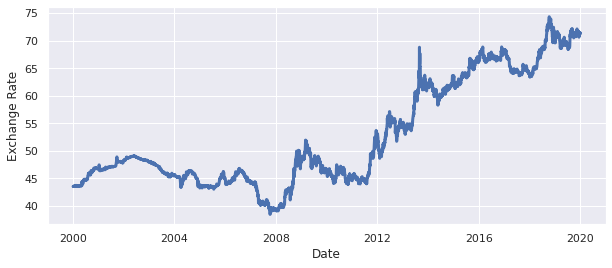

In [58]:
plt.figure(figsize=(10,4)) 
plt.xlabel('Date') 
plt.ylabel('Exchange Rate') 
plt.plot(df['INDIA'])

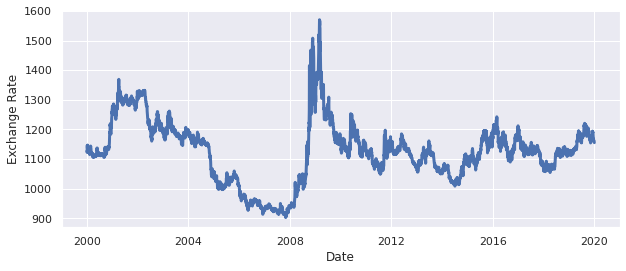

In [59]:
plt.figure(figsize=(10,4)) 
plt.xlabel('Date') 
plt.ylabel('Exchange Rate') 
plt.plot(df['KOREA'])

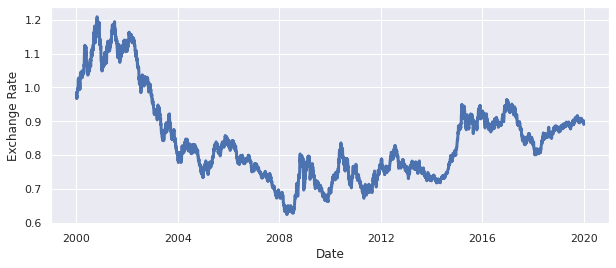

In [60]:
plt.figure(figsize=(10,4)) 
plt.xlabel('Date') 
plt.ylabel('Exchange Rate') 
plt.plot(df['EURO AREA'])

So, the dataframe that we have is a multivariate timeseries. we can either work with this multivariate data or convert it into univariate and work with single country's stock. we are going to work with indian stock.

In [156]:
unidf = finaldf.drop(columns=['AUSTRALIA'	,'EURO AREA'	,'NEW ZEALAND'	,'UNITED KINGDOM'	,'BRAZIL'	,'CANADA'	,'CHINA'	,'HONG KONG'	,'KOREA'	,'MEXICO'	,'SOUTH AFRICA'	,'SINGAPORE'	,'DENMARK' ,'JAPAN','MALAYSIA','NORWAY','SWEDEN','SRI LANKA'	,'SWITZERLAND','TAIWAN','THAILAND'])
unidf

,INDIA
DATE,
2000-01-03,43.55
2000-01-04,43.55
2000-01-05,43.55
2000-01-06,43.55
2000-01-07,43.55
...,...
2019-12-27,71.45
2019-12-28,71.40
2019-12-29,71.35


# **Dickey Fuller Test**

we have to check whether the datis stationary or not if the data is stationary forecasting will be worthless

In [0]:
from statsmodels.tsa.stattools import adfuller
def adfuller_test(ts):
  adfuller_result = adfuller(ts, autolag=None)
  adfuller_out = pd.Series(adfuller_result[0:4],
  index=["Test Statistic","p-value","Lags Used","Number of Observations Used"])
  print(adfuller_out)
  if adfuller_out.iloc[1]> 0.05:
    print('Data is NOT stationary')
  else:
    print('Data is stationary')

In [126]:
adfuller_test(unidf.INDIA)

Test Statistic                   -0.132362
p-value                           0.946118
Lags Used                        33.000000
Number of Observations Used    5183.000000
dtype: float64
Data is NOT stationary


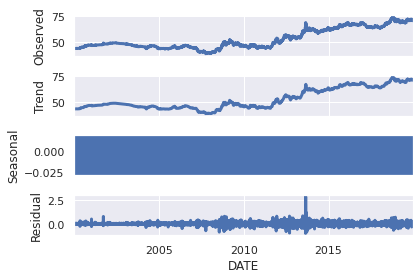

In [219]:
#Degrading into trend, seasonal and residual
from statsmodels.tsa.seasonal import seasonal_decompose
decomposed_result = seasonal_decompose(unidf.INDIA,model='add')
decomposed_result.plot();

In [220]:
decomposed_result.seasonal.head(50)
#Here it can be inferred that seasonality has a period of a week

DATE
2000-01-03    0.011160
2000-01-04    0.017230
2000-01-05    0.008852
2000-01-06    0.003958
2000-01-07   -0.026145
2000-01-08   -0.013735
2000-01-09   -0.001320
2000-01-10    0.011160
2000-01-11    0.017230
2000-01-12    0.008852
2000-01-13    0.003958
2000-01-14   -0.026145
2000-01-15   -0.013735
2000-01-16   -0.001320
2000-01-17    0.011160
2000-01-18    0.017230
2000-01-19    0.008852
2000-01-20    0.003958
2000-01-21   -0.026145
2000-01-22   -0.013735
2000-01-23   -0.001320
2000-01-24    0.011160
2000-01-25    0.017230
2000-01-26    0.008852
2000-01-27    0.003958
2000-01-28   -0.026145
2000-01-29   -0.013735
2000-01-30   -0.001320
2000-01-31    0.011160
2000-02-01    0.017230
2000-02-02    0.008852
2000-02-03    0.003958
2000-02-04   -0.026145
2000-02-05   -0.013735
2000-02-06   -0.001320
2000-02-07    0.011160
2000-02-08    0.017230
2000-02-09    0.008852
2000-02-10    0.003958
2000-02-11   -0.026145
2000-02-12   -0.013735
2000-02-13   -0.001320
2000-02-14    0.011160
2000-0

In [0]:
#splitting into test and train data
train = unidf.loc[:"2019-11-30"]
test = unidf.loc["2019-12-01":"2019-12-31"]

# **Forecasting**

**Moving Average**

In [300]:
train['sma'] = train.INDIA.rolling(window= 2).mean()
train.tail()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,INDIA,sma
DATE,,
2019-11-26,71.510000,71.600000
2019-11-27,71.260000,71.385000
2019-11-28,71.505000,71.382500
2019-11-29,71.750000,71.627500
2019-11-30,71.716667,71.733333


In [301]:
#Predicting from SMA
def SMA_prediction(periods):
  train1 = train.sma.values
  train2 = train1.tolist()
  pred = []
  for i in range(periods):
    c_batch = train2[-30:]
    next_pred = sum(c_batch) /(30)
    train2.append(next_pred)
    pred.append(next_pred)
  return pred
  


test['SMA_prediction'] = SMA_prediction(31)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


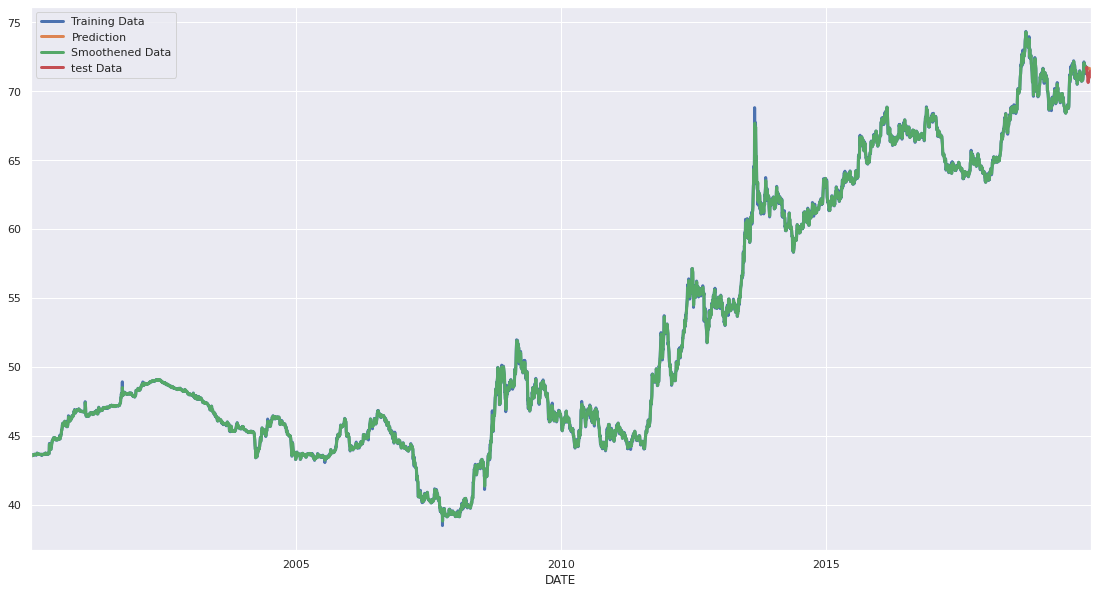

In [302]:
#Visualising price
train.INDIA.plot(figsize = (19,10),legend = True, label = 'Training Data')
test['SMA_prediction'].plot(figsize = (19,10),legend = True, label = 'Prediction')
train.sma.plot(figsize = (19,10),legend = True, label = 'Smoothened Data')
test['INDIA'].plot(figsize = (19,10),legend = True, label = 'test Data')

Moving average give us a broader view, and we can now gauge the general direction of its future price. So, here we feed moving average 5000 reading of our given data and forcast the rest of the given data.If we look at original plot and the forecasted plot, general direction of the stocks seems similiar. 

In [0]:
def get_mape(actual, predicted):
  y_true, y_pred = np.array(actual), np.array(predicted)
  return np.round( np.mean(np.abs((actual - predicted) / actual))* 100, 2 )

In [228]:
get_mape(test.INDIA,test['SMA_prediction'])

0.68

By the plot its hard to understand if there is any error or fault in our forecast. So, we check the mean absolute error of the moving average which is **0.68** which is quite decent.

In [229]:
print(np.sqrt(mean_squared_error(test.INDIA,test['SMA_prediction'])))

0.5442324576503398


 **Exponential Smoothing**

The drawbacks of the simple moving average technique is that it gives equal weight to all the previous observations used in forecasting the future value. Exponential smoothing technique assigns diﬀerential weights to past observations.

In [306]:
train['wma'] = train.INDIA.ewm(span=2,).mean()
train

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,INDIA,sma,wma
DATE,,,
2000-01-03,43.550000,NaN,43.550000
2000-01-04,43.550000,43.550000,43.550000
2000-01-05,43.550000,43.550000,43.550000
2000-01-06,43.550000,43.550000,43.550000
2000-01-07,43.550000,43.550000,43.550000
...,...,...,...
2019-11-26,71.510000,71.600000,71.573744
2019-11-27,71.260000,71.385000,71.364581
2019-11-28,71.505000,71.382500,71.458194


In [307]:
def WMA_prediction(periods):
  train1 = train.wma.values
  train2 = train1.tolist()
  pred = []
  for i in range(periods):
    c_batch = train2[-30:]
    next_pred = sum(c_batch) /30
    train2.append(next_pred)
    pred.append(next_pred)
  return pred
  


test['WMA_prediction'] = WMA_prediction(31)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


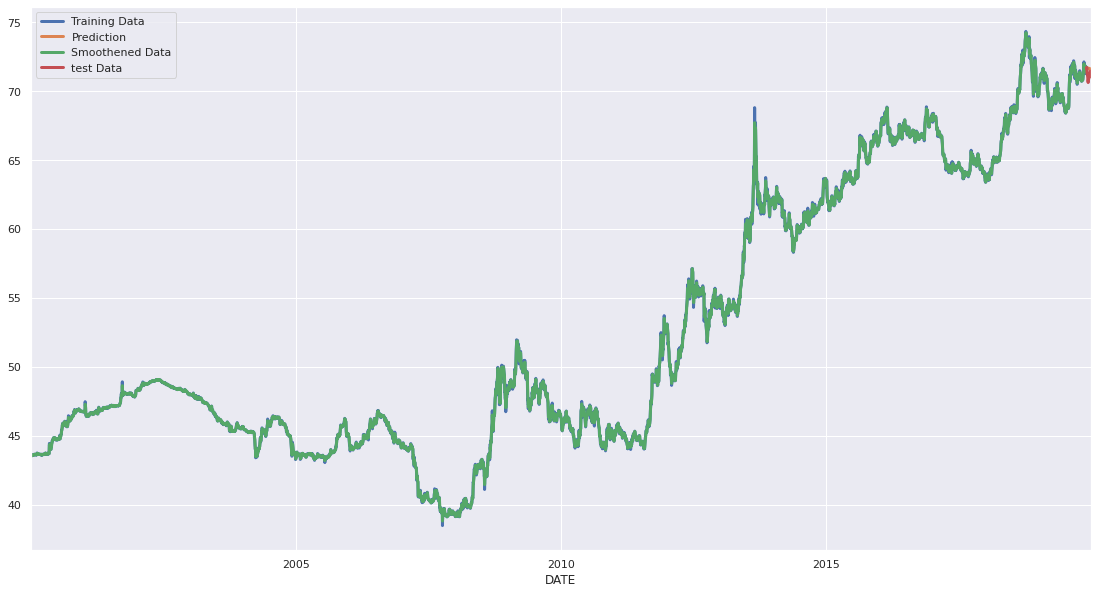

In [233]:
train.INDIA.plot(figsize = (19,10),legend = True, label = 'Training Data')
test['WMA_prediction'].plot(figsize = (19,10),legend = True, label = 'Prediction')
train.wma.plot(figsize = (19,10),legend = True, label = 'Smoothened Data')
test['INDIA'].plot(figsize = (19,10),legend = True, label = 'test Data')

so,we did forcast with expoential smoothing and in its plot we see there is general direction of the future stock is quite similar to moving average plot.so me need to check the mean absolute error(MAE).

In [308]:
test

,INDIA,SMA_prediction,WMA_prediction
DATE,,,
2019-12-01,71.683333,71.473611,71.473419
2019-12-02,71.650000,71.493231,71.494787
2019-12-03,71.700000,71.517506,71.518253
2019-12-04,71.470000,71.542256,71.542742
2019-12-05,71.260000,71.567498,71.567904
2019-12-06,71.260000,71.593081,71.593413
2019-12-07,71.180000,71.616684,71.616276
2019-12-08,71.100000,71.637240,71.636957
2019-12-09,71.020000,71.651981,71.650457


In [235]:
get_mape(test.INDIA,test['WMA_prediction'])

0.68

In [234]:
print(np.sqrt(mean_squared_error(test.INDIA,test['WMA_prediction'])))

0.5441636046916125


so, MAE is **0.68** is same and RSME is quite small **0.5441636046916125**

**ACF**

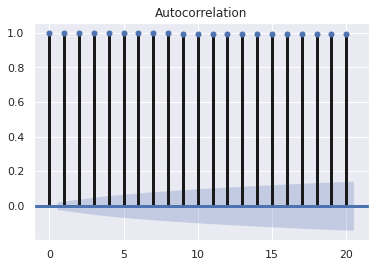

In [69]:
acf_plot = plot_acf( unidf.INDIA,lags=20)
# Significant coorelation between lags 

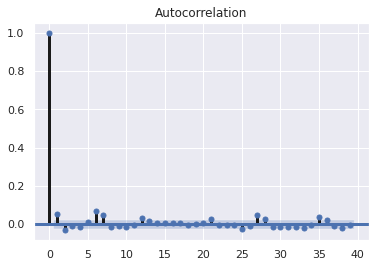

In [70]:
#1st Order Differencing
acf_plot=plot_acf(unidf.INDIA.diff().dropna())

One lag can be found above the significance level and thus q = 1.

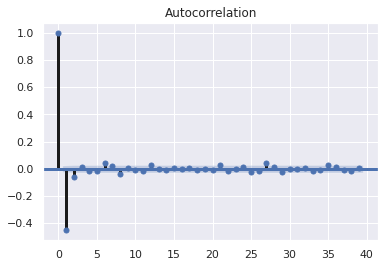

In [71]:
#2nd Order Differencing
acf_plot = plot_acf(unidf.INDIA.diff().diff().dropna())

The timeseries is stationary at d = 1 where only the first lag is above the significance level

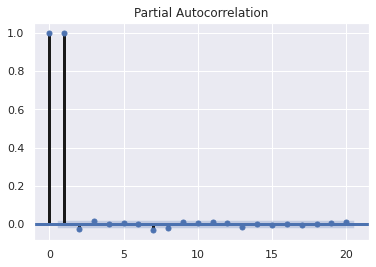

In [72]:
# No significant pattern in pacf
pacf_plot = plot_pacf( unidf.INDIA,lags=20 )

The first two lags are the one vastly above the signicance level and so p = 2.

ARIMA stands for Autoregressive Integrated Moving Average and it depends on three key variables p, d, q to be successful
p = number of lags / order of AR terms
d = order of differencing
q = number of lagged forecast errors / order of MA terms

**Auto regressive model**

In [73]:
from statsmodels.tsa.arima_model import ARIMA
arima = ARIMA(unidf.INDIA[0:], order = (2,0,0))
ar_model = arima.fit()
ar_model.summary2()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: ARMA
====================================================================
Model:              ARMA             BIC:                 -4409.1919
Dependent Variable: INDIA            Log-Likelihood:      2222.4    
Date:               2020-05-01 06:20 Scale:               1.0000    
No. Observations:   7303             Method:              css-mle   
Df Model:           3                Sample:              01-03-2000
Df Residuals:       7300                                  12-31-2019
Converged:          1.0000           S.D. of innovations: 0.178     
No. Iterations:     30.0000          HQIC:                -4427.291 
AIC:                -4436.7760                                      
---------------------------------------------------------------------
                 Coef.   Std.Err.     t      P>|t|    [0.025   0.975]
---------------------------------------------------------------------
const           56.0561   10.4634    5.3573  0.0000  35.5482  76.5641
ar.L1.INDIA      1.0540    0.0019  566.2197  0.0000   1.0504   1.0577
ar.L2.INDIA     -0.0541    0.0019  -29.0696  0.0000  -0.0578  -0.0505
-----------------------------------------------------------------------------
                 Real           Imaginary          Modulus          Frequency
-----------------------------------------------------------------------------
AR.1            1.0001             0.0000           1.0001             0.0000
AR.2           18.4762             0.0000          18.4762             0.0000
====================================================================

"""

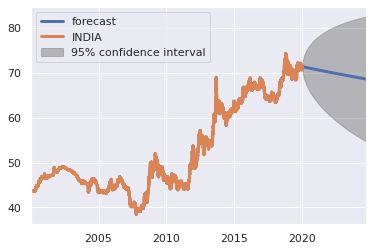

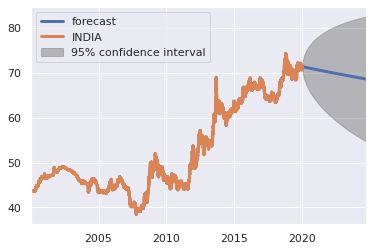

In [74]:
ar_model.plot_predict(1, 9000)

Akaike information criterion (AIC) estimates the relative amount of information lost by a given model. The less the better.


In [75]:
forecast_ar = ar_model.predict(5000)
get_mape( unidf.INDIA[5000:],forecast_ar )

0.19

**Moving average model**

In [76]:
arima = ARIMA(unidf.INDIA[0:7303], order = (0,0,1))
ma_model = arima.fit()
ma_model.summary2()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: ARMA
====================================================================
Model:              ARMA             BIC:                 43974.1400
Dependent Variable: INDIA            Log-Likelihood:      -21974.   
Date:               2020-05-01 06:20 Scale:               1.0000    
No. Observations:   7303             Method:              css-mle   
Df Model:           2                Sample:              01-03-2000
Df Residuals:       7301                                  12-31-2019
Converged:          1.0000           S.D. of innovations: 4.902     
No. Iterations:     5.0000           HQIC:                43960.566 
AIC:                43953.4519                                      
---------------------------------------------------------------------
                 Coef.   Std.Err.     t      P>|t|    [0.025   0.975]
---------------------------------------------------------------------
const           52.7614    0.1141  462.2993  0.0000  52.5378  52.9851
ma.L1.INDIA      0.9897    0.0013  778.6516  0.0000   0.9872   0.9922
-----------------------------------------------------------------------------
                 Real           Imaginary          Modulus          Frequency
-----------------------------------------------------------------------------
MA.1           -1.0104             0.0000           1.0104             0.5000
====================================================================

"""

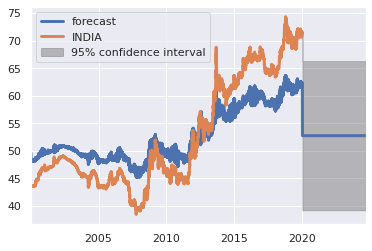

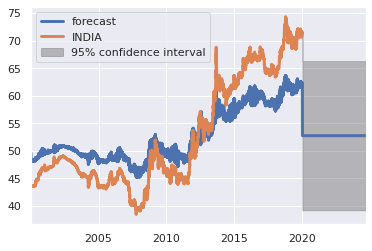

In [77]:
ma_model.plot_predict(1, 9000)

In [78]:
forecast_ma = ma_model.predict(5000)
get_mape( unidf.INDIA[5000:],forecast_ma )

9.87

**ARIMA model**

In [259]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train.INDIA, order=(2, 1, 1))
arima_model = model.fit()
arima_model.summary2()


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: ARIMA
====================================================================
Model:              ARIMA            BIC:                 -4380.9950
Dependent Variable: D.INDIA          Log-Likelihood:      2212.7    
Date:               2020-05-01 10:16 Scale:               1.0000    
No. Observations:   7271             Method:              css-mle   
Df Model:           4                Sample:              01-04-2000
Df Residuals:       7267                                  11-30-2019
Converged:          1.0000           S.D. of innovations: 0.178     
No. Iterations:     6.0000           HQIC:                -4403.602 
AIC:                -4415.4532                                      
---------------------------------------------------------------------
                  Coef.   Std.Err.     t     P>|t|    [0.025   0.975]
---------------------------------------------------------------------
const             0.0039    0.0021   1.8322  0.0670  -0.0003   0.0080
ar.L1.D.INDIA     0.2535    0.2328   1.0890  0.2762  -0.2027   0.7097
ar.L2.D.INDIA    -0.0474    0.0158  -2.9950  0.0028  -0.0784  -0.0164
ma.L1.D.INDIA    -0.1984    0.2329  -0.8519  0.3943  -0.6549   0.2581
-----------------------------------------------------------------------------
                 Real           Imaginary          Modulus          Frequency
-----------------------------------------------------------------------------
AR.1            2.6731            -3.7342           4.5924            -0.1511
AR.2            2.6731             3.7342           4.5924             0.1511
MA.1            5.0400             0.0000           5.0400             0.0000
====================================================================

"""

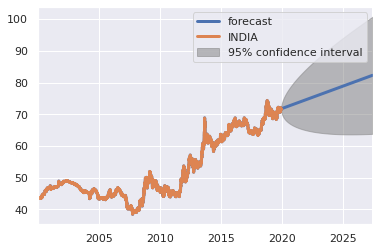

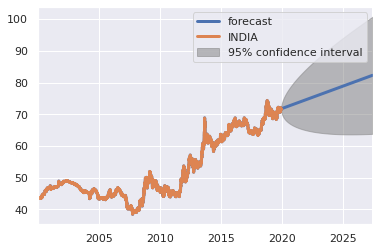

In [260]:
arima_model.plot_predict(1, 10000)

with arima we tried to forecast a bigger range though this could be not totally acccurate it gives us range and directions pf the stocks with 95% confidence.

In [0]:
arima_model_prediction = arima_model.forecast(31)

**Auto ARIMA**

In [212]:
!pip install pmdarima
from pmdarima import auto_arima # for determining ARIMA orders
stepwise_fit = auto_arima(train.INDIA,m=12,
                          seasonal=True,
                          d=None, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

stepwise_fit.summary()

     |████████████████████████████████| 1.5MB 2.8MB/s 
Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(1, 0, 1, 12) (constant=True); AIC=-4128.959, BIC=-4074.634, Time=40.632 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 12) (constant=True); AIC=-4110.799, BIC=-4097.218, Time=0.477 seconds
Fit ARIMA: (1, 1, 0)x(1, 0, 0, 12) (constant=True); AIC=-4126.666, BIC=-4099.504, Time=5.174 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 1, 12) (constant=True); AIC=-4127.657, BIC=-4100.495, Time=6.737 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 12) (constant=False); AIC=-4110.824, BIC=-4104.034, Time=0.190 seconds
Fit ARIMA: (2, 1, 2)x(0, 0, 1, 12) (constant=True); AIC=-4130.177, BIC=-4082.643, Time=31.942 seconds
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 12) (constant=True); AIC=-4124.122, BIC=-4083.378, Time=9.688 seconds
Fit ARIMA: (2, 1, 2)x(0, 0, 2, 12) (constant=True); AIC=-4128.274, BIC=-4073.950, Time=96.127 seconds
Fit ARIMA: (2, 1, 2)x(1, 0, 0, 12) (constant=True); AIC=-4130.098, BIC=-4082.564, Time=43.

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 6573
Model:             SARIMAX(0, 1, 2)x(0, 0, 1, 12)   Log Likelihood                2071.950
Date:                            Fri, 01 May 2020   AIC                          -4133.901
Time:                                    08:33:31   BIC                          -4099.948
Sample:                                         0   HQIC                         -4122.164
                                           - 6573                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0031      0.002      1.295      0.195      -0.002       0.008
ma.L1          0.0436      0.004     10.081      0.000       0.035       0.052
ma.L2         -0.0358      0.006     -5.596      0.000      -0.048      -0.023
ma.S.L12       0.0351      0.007      4.989      0.000       0.021       0.049
sigma2         0.0312      0.000    196.221      0.000       0.031       0.031
===================================================================================
Ljung-Box (Q):                       97.28   Jarque-Bera (JB):            157999.08
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               9.17   Skew:                            -0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                        27.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

so by auto arima me get the best parameters results and its suggested SARIMAX function gives best results with order(0,1,2)

In [238]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train.INDIA,order=(0,1,2),enforce_invertibility=False)
result_SARIMAX = model.fit()
result_SARIMAX.summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  INDIA   No. Observations:                 7272
Model:               SARIMAX(0, 1, 2)   Log Likelihood                2210.787
Date:                Fri, 01 May 2020   AIC                          -4415.575
Time:                        10:07:27   BIC                          -4394.900
Sample:                    01-03-2000   HQIC                         -4408.464
                         - 11-30-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0554      0.004     12.918      0.000       0.047       0.064
ma.L2         -0.0334      0.006     -5.382      0.000      -0.046      -0.021
sigma2         0.0319      0.000    195.773      0.000       0.032       0.032
===================================================================================
Ljung-Box (Q):                      122.06   Jarque-Bera (JB):            136699.31
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               7.28   Skew:                            -0.34
Prob(H) (two-sided):                  0.00   Kurtosis:                        24.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [0]:
result_SARIMAX_prediction = result_SARIMAX.forecast(31)

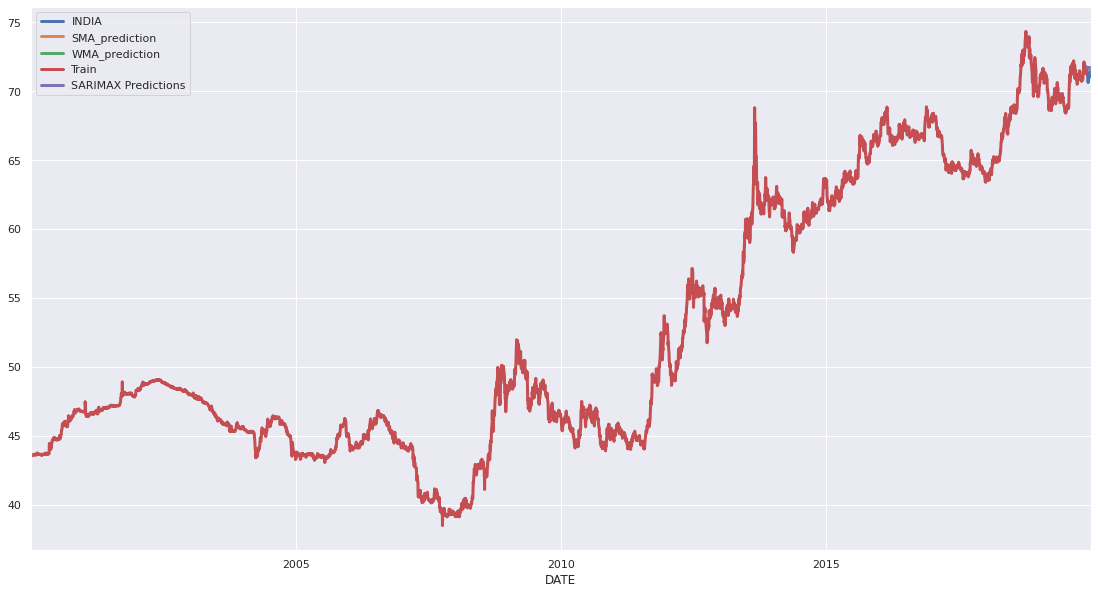

In [240]:
test.plot(legend=True,label='TEST')
train.INDIA.plot(legend=True,label='Train')
result_SARIMAX_prediction.plot(legend=True,label='SARIMAX Predictions',figsize=(19,10));


In [241]:
get_mape(unidf.INDIA["2019-12-01":"2019-12-31"],result_SARIMAX_prediction.values)

0.76

In [247]:
print(np.sqrt(mean_squared_error(test.INDIA,result_SARIMAX_prediction.values)))

0.6025859491776253


# **Modelling**

**LSTM**

In [0]:
# Data Conversion Utility

def getTimeSeriesData(A, window=7):
    X, y = list(), list()
    for i in range(len(A)):
        end_ix = i + window
        if end_ix > len(A) - 1:
            break
        seq_x, seq_y = A[i:end_ix], A[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [249]:
window = 2
num_features = 1

X, y = getTimeSeriesData(list(unidf["INDIA"]), window=window)
print("X:", X.shape)
print("Y:", y.shape)

# We need to add one more dimension to X, i.e Num of features in 1 sample of time step. as we are doing a univariate prediction which means number of features are 1 only
X = X.reshape((X.shape[0], X.shape[1], num_features))  # For LSTM
print("-----------")
print("X:", X.shape)
print("Y:", y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("-----------")
print("X train:", X_train.shape)
print("y train:", y_train.shape)
print("X test:", X_test.shape)
print("y test:", y_test.shape)

X: (7301, 2)
Y: (7301,)
-----------
X: (7301, 2, 1)
Y: (7301,)
-----------
X train: (5110, 2, 1)
y train: (5110,)
X test: (2191, 2, 1)
y test: (2191,)


In [250]:
# Define Model
model = Sequential()
model.add(LSTM(7, activation='relu', input_shape=(window, num_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=20, verbose=1)

Epoch 1/20
5110/5110 [==============================] - 1s 111us/step - loss: 2138.8606
Epoch 2/20
5110/5110 [==============================] - 0s 60us/step - loss: 15.5240
Epoch 3/20
5110/5110 [==============================] - 0s 58us/step - loss: 0.4998
Epoch 4/20
5110/5110 [==============================] - 0s 65us/step - loss: 0.4665
Epoch 5/20
5110/5110 [==============================] - 0s 61us/step - loss: 0.4311
Epoch 6/20
5110/5110 [==============================] - 0s 58us/step - loss: 0.3935
Epoch 7/20
5110/5110 [==============================] - 0s 59us/step - loss: 0.3569
Epoch 8/20
5110/5110 [==============================] - 0s 59us/step - loss: 0.3209
Epoch 9/20
5110/5110 [==============================] - 0s 59us/step - loss: 0.2854
Epoch 10/20
5110/5110 [==============================] - 0s 59us/step - loss: 0.2477
Epoch 11/20
5110/5110 [==============================] - 0s 60us/step - loss: 0.1533
Epoch 12/20
5110/5110 [==============================] - 0s 60us/step

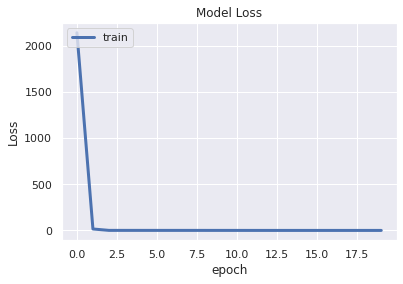

In [251]:
plt.plot(history.history["loss"])
#plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [252]:
yPred = model.predict(X_test, verbose=0)
yPred.shape = yPred.shape[0]
yPred

array([48.317833, 49.64553 , 44.34499 , ..., 62.437443, 46.06539 ,
       69.356476], dtype=float32)

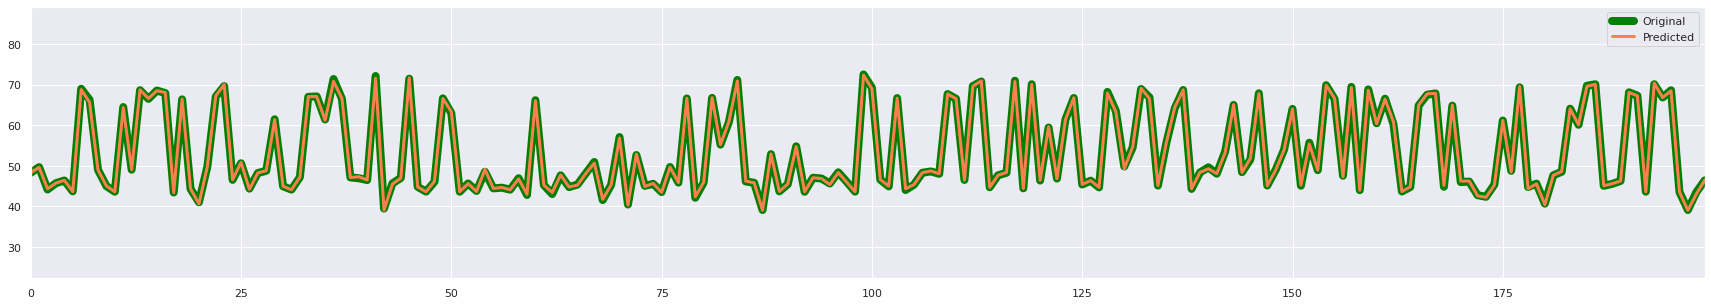

In [253]:
points = 200
plt.figure(figsize=(30,5))
sns.set(rc={"lines.linewidth": 8})
sns.lineplot(x=np.arange(points), y=y_test[:points], color="green")
sns.set(rc={"lines.linewidth": 3})
sns.lineplot(x=np.arange(points), y=yPred[:points], color="coral")
plt.margins(x=0, y=0.5)
plt.legend(["Original", "Predicted"])

In [254]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
print(mean_absolute_error(y_test, yPred))
print(mean_squared_error(y_test, yPred))
print(np.sqrt(mean_squared_error(y_test, yPred)))

0.13977073392703124
0.04916412745516259
0.22172985242218196


# **References**

1.   https://www.babypips.com/learn/forex/simple-moving-averages
3. https://www.kaggle.com/voltvipin/indian-foreign-exchange-prediction-using-lstm
4.  https://towardsdatascience.com/arima-forecasting-in-python-90d36c2246d3    
5.  https://www.geeksforgeeks.org/working-with-missing-data-in-pandas/